# **ExoHunt**



---



## **Table of Contents**

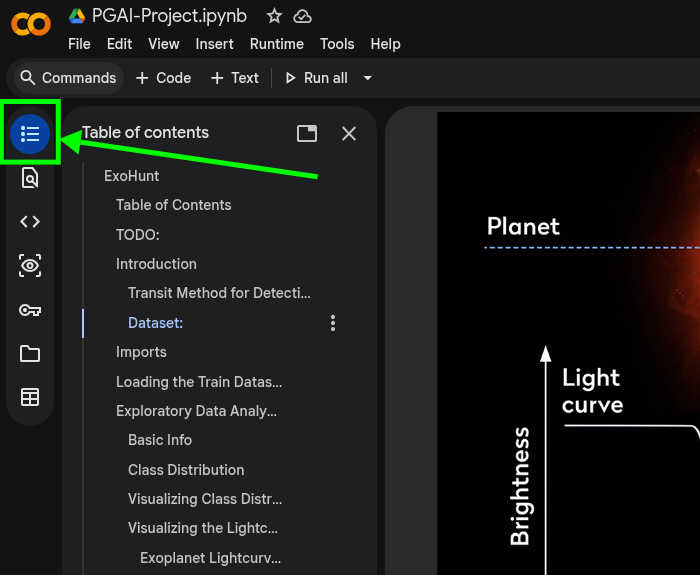

## **Introduction**
### **Overview:**
The discovery of exoplanets—planets orbiting stars outside our solar system—
is one of the most significant developments in modern astronomy. The
ExoHunt project aims to apply Machine Learning (ML) techniques to
automate the detection of stars that have a high probability of hosting
exoplanets. By analyzing photometric data from the NASA Kepler Space
Telescope, this project seeks to classify stars into two categories: those with
exoplanets and those without.
The primary goal of this final Machine Learning model is to significantly
reduce the search space for astronomers. By filtering through thousands of
stars and identifying promising candidates, we can optimize the usage of
more powerful and resource-constrained telescopes (such as the James
Webb Space Telescope) for detailed confirmation observations.

### **Transit Method for Detecting Exoplanets:**
This project utilizes the Transit Method of detection. This method relies on the
observation of a star's brightness (flux) over time, known as a Light Curve.
When a planet crosses in front of its host star (transits) relative to the
observer, it blocks a small fraction of the star's light, causing a periodic dip in
brightness.
![Transit Method](https://c02.purpledshub.com/uploads/sites/48/2022/05/exoplanet-transit-6ca9869.jpg)


### **Dataset:**
Source: https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data




---



## **Imports**

In [ ]:
import matplotlib.pyplot as plt  # for plotting charts
from matplotlib.lines import Line2D
import numpy as np  # for fast data processing and storage
import pandas as pd  # for data analysis

# imports for checking model performace
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
    make_scorer,
    f1_score,
    recall_score,
    precision_recall_curve,
    confusion_matrix
)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage import gaussian_filter1d #for gaussian smoothing

plt.style.use("ggplot")

## **Loading the Train Dataset**

Read the CSV file into a Pandas DataFrame.

In [ ]:
# download dataset from kaggle, and import it
import kagglehub

path = kagglehub.dataset_download("keplersmachines/kepler-labelled-time-series-data")

orig_train_df = pd.read_csv(path + "/exoTrain.csv")
test_df = pd.read_csv(path + "/exoTest.csv")

100%|██████████| 55.9M/55.9M [00:00<00:00, 141MB/s]

Extracting files...


## **Exploratory Data Analysis (EDA)**

### **Basic Info**

The train dataset has 5087 samples with 3198 features. The first column is the label vector while the rest are flux observations of a star over time.

In [ ]:
orig_train_df.shape

(5087, 3198)

In [ ]:
orig_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


The column names of the flux observations have the following convention: FLUX.N where N is the Nth observation.

In [ ]:
orig_train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Changing the labels from 1 (for non-exoplanets) and 2 (for exoplanets) to 0 and 1 respectively. This is standard practice.

In [ ]:
orig_train_df["LABEL"] = orig_train_df["LABEL"] - 1

### **Class Distribution**

In [ ]:
# value_counts() function gives the count of unique values in a column.
# the `LABEL` column has two unique values (namely 0 and 1)
orig_class_distribution = orig_train_df["LABEL"].value_counts()
display(orig_class_distribution)

,count
LABEL,
0,5050
1,37


### **Visualizing Class Distribution**

In [ ]:
def visualize_class_distribution(class_distribution: pd.Series) -> None:
    '''
    Visualize distribution of classes using bar and donut charts.
    Args:
    label_dist (pd.Series): The result of value_counts() function on a column
    Returns:
    None
    '''

    '''
    Make a figure with two subplots (both of them on a single row).
    ax is a tuple containing the subplots.
    ax[0] is the first subplot
    ax[1] is the second subplot

    To further learn about figure and axes objects, go to https://matplotlib.org/stable/users/explain/quick_start.html
    '''
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    '''
    label_dist.index represents the x axis values
    label_dist.values represents the y axis values
    1 -> 5050
    2 -> 37
    '''
    ax[0].bar(class_distribution.index, class_distribution.values, color=["#E24A33", "#348ABD"]) #bar chart
    ax[0].set_xlabel("Classes")
    ax[0].set_ylabel("Frequency")
    ax[0].set_xticks([0, 1], ["Non-Exoplanets", "Exoplanets"]) # Only two classes so we need only two x axis values


    '''
    - autopct is for showing percentages on the pie chart (Even I dont understand the %1.1f%% part. I copied it from stackoverflow)

    - wedgeprops=dict(width=0.5) makes the pie chart into a donut chart. width parameter sets the size of the middle hole

    - pctdistance sets how close to the center of the circle the percentage labels are.
    '''
    ax[1].pie(class_distribution, labels=["Non-Exoplanets", "Exoplanets"], autopct="%1.1f%%", wedgeprops=dict(width=0.5), pctdistance=0.75)
    ax[1].legend() # to show which color maps to which class label

    plt.suptitle("Distribution of Non-Exoplanets vs Exoplanets") # suptitle is short for super title. It is to give a set of plots a single title.
    plt.show()

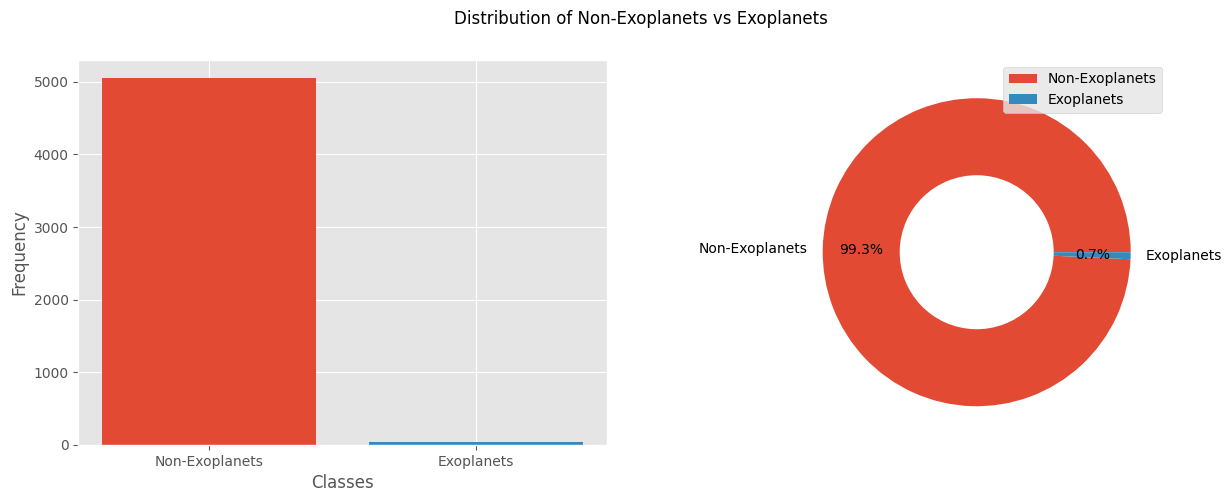

In [ ]:
visualize_class_distribution(orig_class_distribution)

As we can see, the number of stars with exoplanets are vastly outnumbered by stars which do not. This is a class imbalance which will need to be addressed before we move on to model training.

### **Visualizing the Lightcurves of Each Class**

Seperating the original dataframe to make two dataframes, one consisting of only exoplanets and the other consisting of only non-exoplanets

In [ ]:
exo_df: pd.DataFrame = orig_train_df[orig_train_df["LABEL"] == 1]
noexo_df: pd.DataFrame = orig_train_df[orig_train_df["LABEL"] == 0]

In [ ]:
def lightcurve_plot(df: pd.DataFrame, no_of_plots: int, title: str = None, shuffle:bool = True) -> None:
    '''
    Plots the lightcurve. Lightcurve is the plot of flux (brightness) values of a object over time.

    Args:
        df (pd.DataFrame): DataFrame containing the flux values
        no_of_plots (int): Number of plots to be made
    Returns:
        None
    '''

    fig, ax = plt.subplots(no_of_plots, figsize=(20, 4*no_of_plots))

    if shuffle: df: pd.DataFrame = df.sample(frac=1) #shuffle the dataframe
    for i in range(no_of_plots):
        ax[i].plot(range(df.shape[1] - 1), df.iloc[i, 1:], lw=1.2)
        ax[i].set_xlabel("Flux Observation")
        ax[i].set_ylabel("Flux Value")

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(h_pad=5)
    plt.show()

#### **Exoplanet Lightcurves**

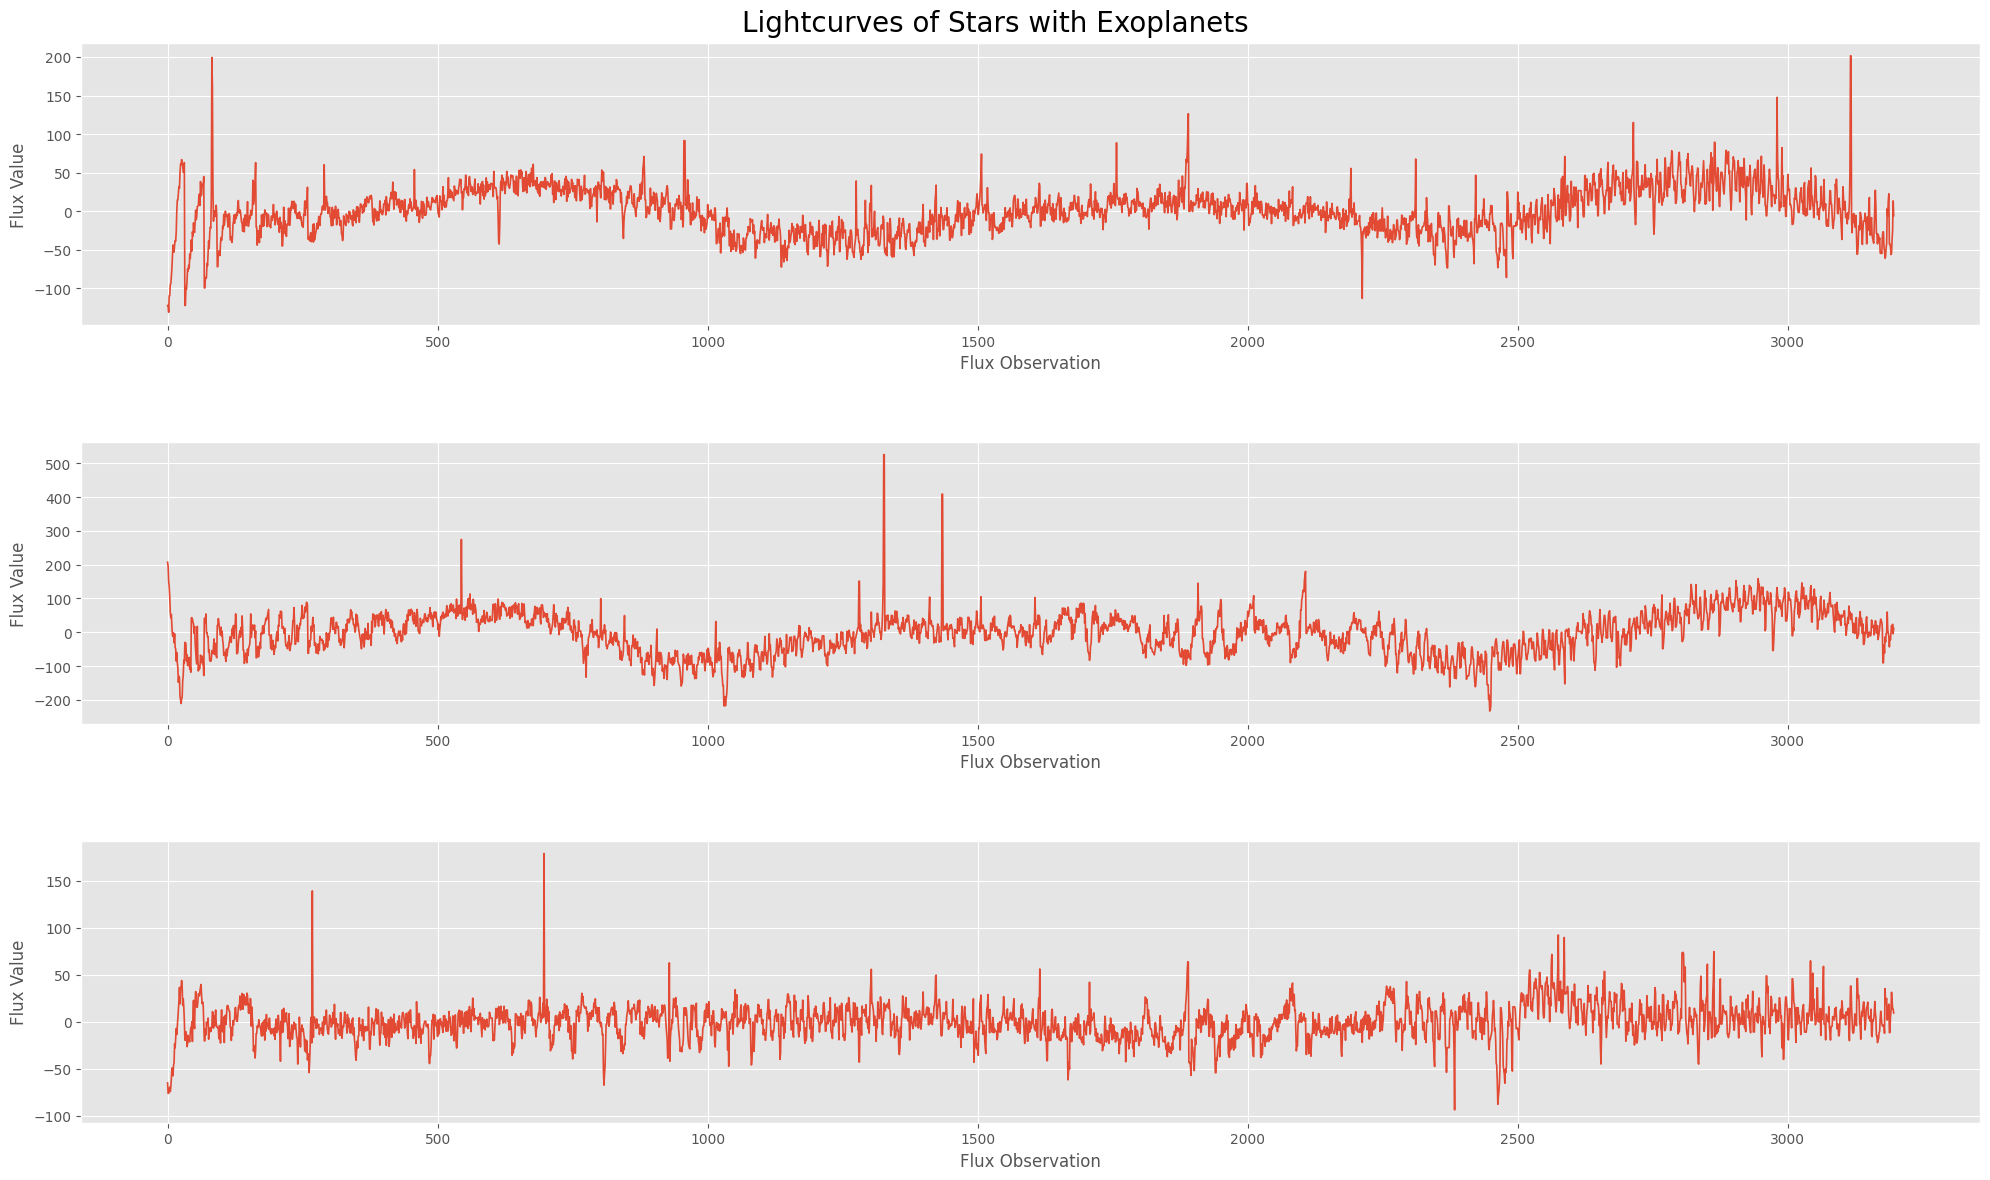

In [ ]:
lightcurve_plot(exo_df, no_of_plots=3, title="Lightcurves of Stars with Exoplanets")

#### **Non-Exoplanet Lightcurves**

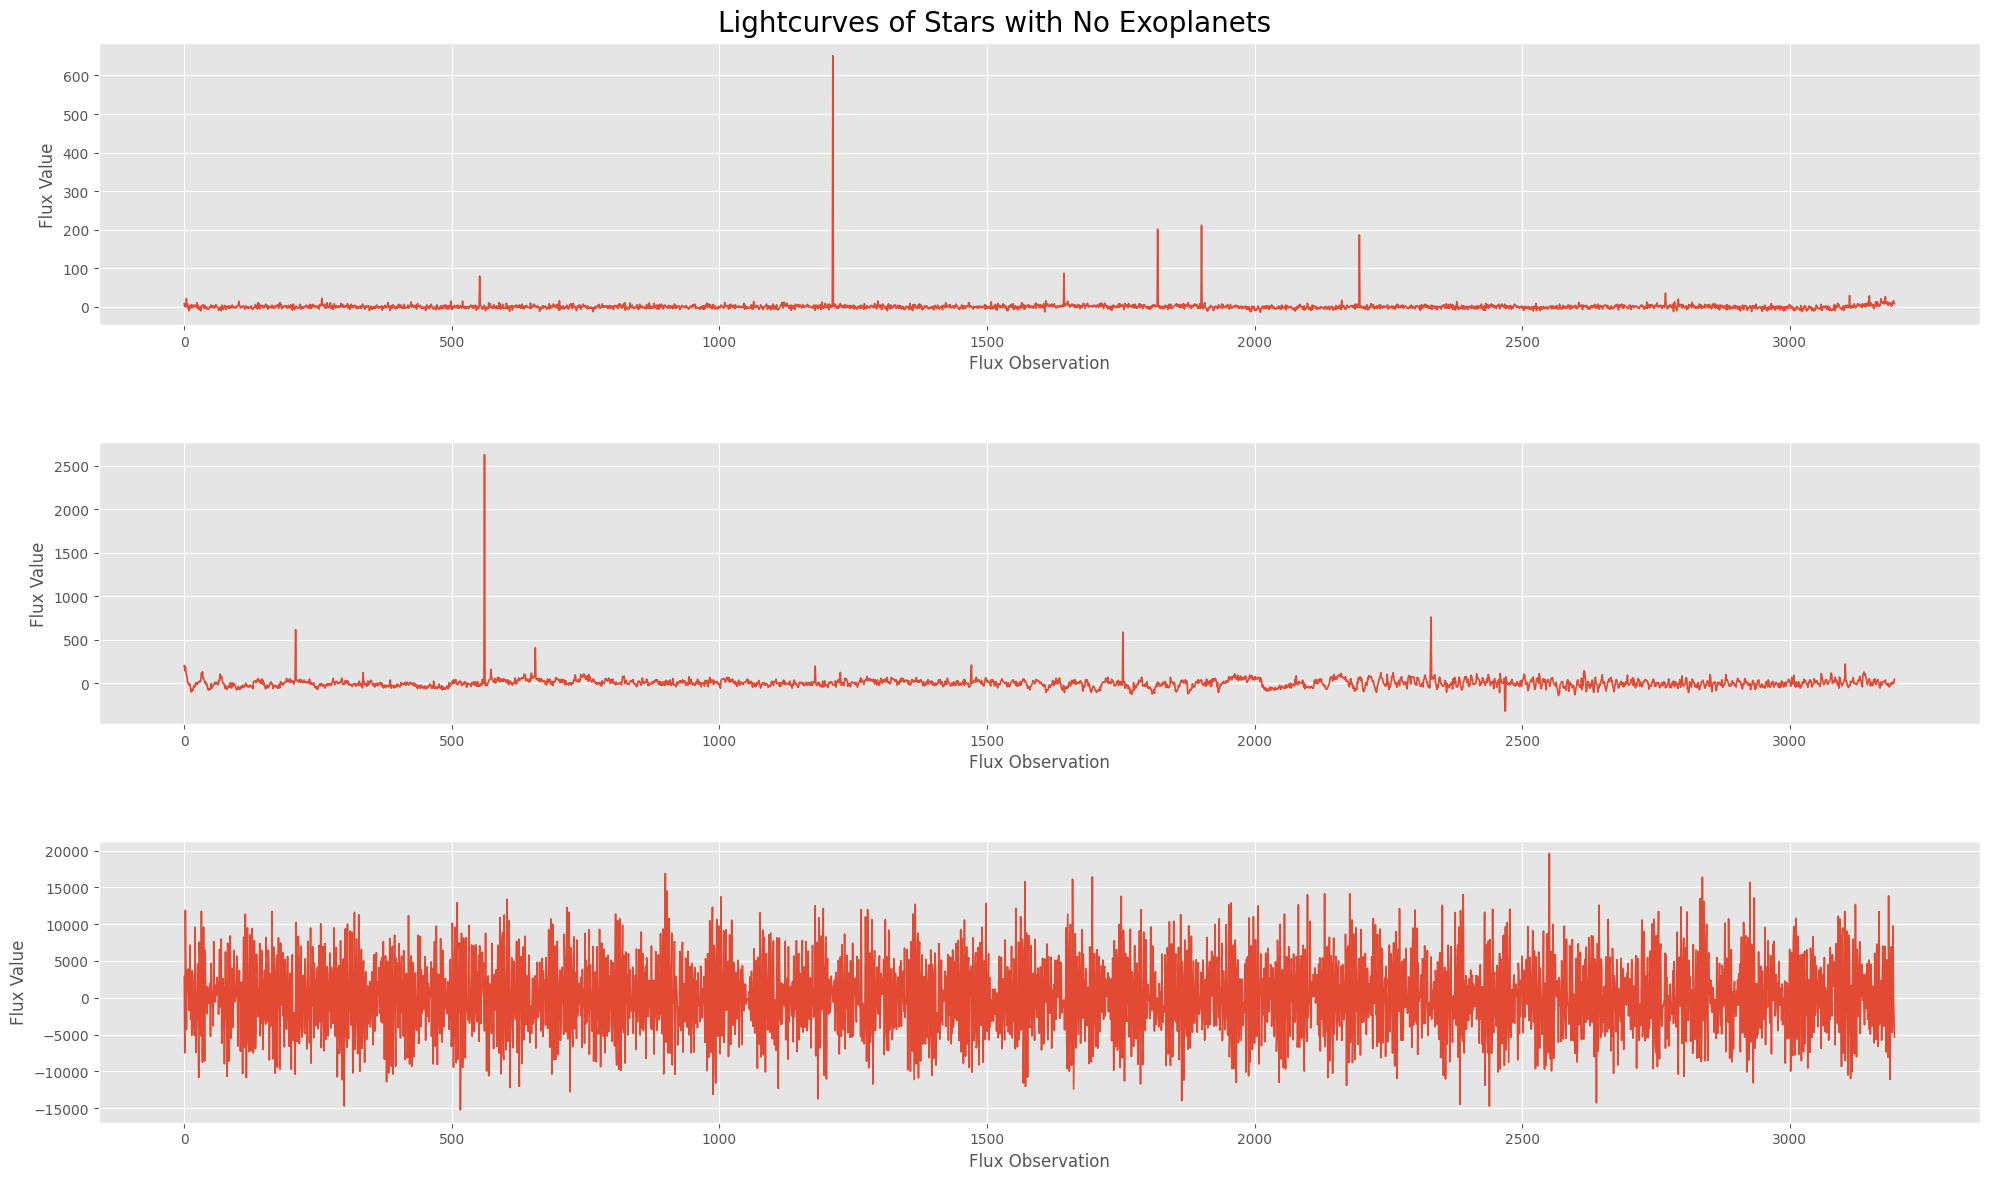

In [ ]:
lightcurve_plot(noexo_df, no_of_plots=3, title="Lightcurves of Stars with No Exoplanets")

As we can see, there seem to be more periodic fluctuations in the exoplanets than the non-exoplanets. This will become the basis for prediction.

## **Preprocessing**

Seperating the original train set into train set and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    orig_train_df.iloc[:, 1:],
    orig_train_df.iloc[:, 0],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

### **Standardization**

Performing Z-Score Standardization. This transforms the data to have mean($\mu$) = 0 and standard deviation($\sigma$) = 1. The formula for this is:
  
$$ z = (x - \mu) / \sigma $$

$z =$  Standardized data point  
$\mu =$  Mean of the data (data would be all observed flux values of the star)  
$\sigma =$  The standard deviation of the data.

In [ ]:
def perform_standardization(df: pd.DataFrame):
    return StandardScaler().fit_transform(df)

### **Guassian Smoothing**

In [ ]:
# Apply Gaussian Smoothing (sigma=1 or 2 is usually best for this dataset)
# This reduces "spikes" while preserving the wide transit dips
def apply_gaussian_smoothing(data: np.ndarray, sigma: int) -> np.ndarray:
    return gaussian_filter1d(data, sigma=sigma, axis=1)

### **Comparing Unsmoothed Data with Data Smoothed with Gaussian Kernel:**

In [ ]:
def compare_normal_to_smoothed(df: pd.DataFrame, index: int, sigma: int = 1) -> None:
    '''
    Compare normal light curve to a one smoothed by gaussian filter
    Args:
        df (pd.DataFrame):
    '''
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    ax[0].plot(range(df.shape[1] - 1), df.iloc[index, 1:], lw=1.2)
    ax[0].set_xlabel("Flux Observation")
    ax[0].set_ylabel("Flux Value")
    ax[0].set_title("Unsmoothed")

    df = pd.DataFrame(apply_gaussian_smoothing(df, sigma))

    ax[1].plot(range(df.shape[1] - 1), df.iloc[index, 1:], lw=1.2)
    ax[1].set_xlabel("Flux Observation")
    ax[1].set_ylabel("Flux Value")
    ax[1].set_title("Smoothed")

    plt.tight_layout(h_pad=5)
    plt.show()

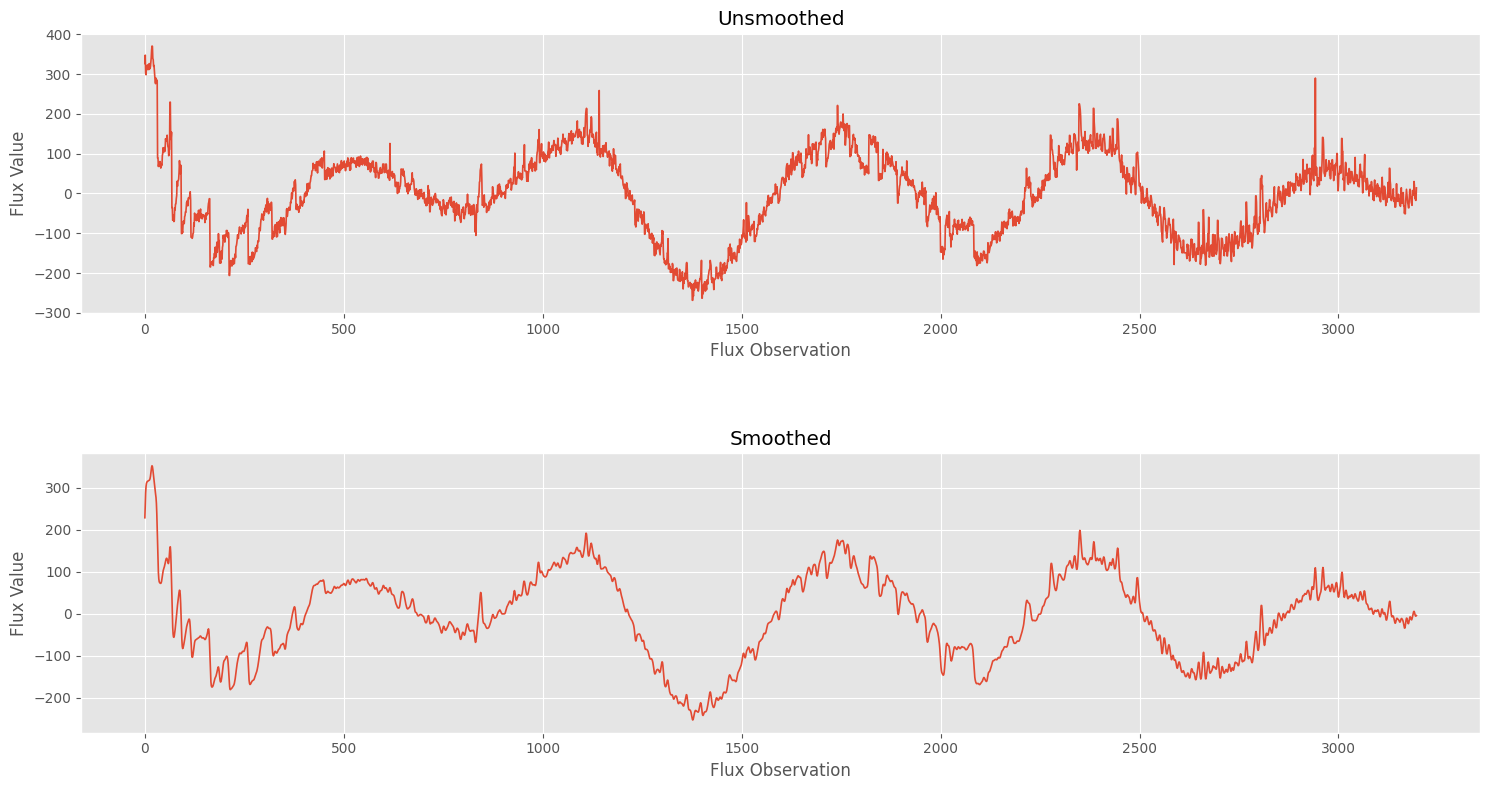

In [ ]:
compare_normal_to_smoothed(orig_train_df, index=3, sigma=2)

As we can see, the intense fluctuations got smoothened out

### **Fast Fourier Transform (FFT)**

In [ ]:
def apply_fft(data: np.ndarray) -> np.ndarray:
    fft_values = np.abs(np.fft.fft(data, axis=1))
    half_point = fft_values.shape[1] // 2
    fft_features = fft_values[:, :half_point]

    return fft_features

Combining all of the above preprocessing functions into a single one

In [ ]:
def preprocess(df: pd.DataFrame, sigma: int = 1) -> np.ndarray:
    df = perform_standardization(df.T).T
    df = apply_gaussian_smoothing(df, sigma=sigma)
    df = apply_fft(df)

    return perform_standardization(df.T).T

In [ ]:
X_train_final = preprocess(X_train)
X_val_final = preprocess(X_val)

## **Helper Functions to Visualize Performace of Models**

In [ ]:
def show_performace_report(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    '''
    Displays the confusion matrix and the classification report of a given model and data

    Args:
        X: The features of the data
        y: The labels of the data
        model: The model to be evaluated
    Returns:
        None
    '''
    print("================   Confusion Matrix and PR Curve ====================\n")
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", ax=ax[0])
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[1])
    ax[0].set_title("Confusion Matrix")
    ax[1].set_title("Precision Recall Curve")
    plt.legend(loc=1)
    ax[0].grid(False)
    plt.show()

    print("\n\n================ Classification Report =================\n")
    print(classification_report(y_true, y_pred))

In [ ]:
def compare_conf_matrices(y1: np.ndarray, y_pred1: np.ndarray, y2: np.ndarray, y_pred2: np.ndarray, title1: str ="Model 1", title2: str ="Model 2") -> None:
    '''
    Functions to compare confusion matrices of two sets of predictions
    Args:
        y1: The true labels of the first set of predictions
        y_pred1: The first set of predictions
        y2: The true labels of the second set of predictions
        y_pred2: The second set of predictions
    Returns:
        None
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    #First confusion matrix
    cm1 = confusion_matrix(y1, y_pred1)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
    disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
    ax1.set_title(title1)
    ax1.grid(False)

    #Second confusion matrix
    cm2 = confusion_matrix(y2, y_pred2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
    ax2.set_title(title2)
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def compare_pr_curve(y1: np.ndarray, y_pred1: np.ndarray, y2: np.ndarray, y_pred2: np.ndarray, title1: str ="Model 1", title2: str ="Model 2") -> None:
    '''
    Functions to compare PR curves of two sets of predictions
    Args:
        y1: The true labels of the first set of predictions
        y_pred1: The first set of predictions
        y2: The true labels of the second set of predictions
        y_pred2: The second set of predictions
    Returns:
        None
    '''
    fig, ax = plt.subplots(figsize=(10, 5))

    PrecisionRecallDisplay.from_predictions(y1, y_pred1, ax=ax, name=title1)
    PrecisionRecallDisplay.from_predictions(y2, y_pred2, ax=ax, name=title2)
    ax.set_title("Precision Recall Curve")
    plt.legend(loc=1)
    plt.show()


## **Model Training**

### **Model Selection and Training using GridSearchCV and SGDClassifier**

In [ ]:
param_grid = {
    'loss': ['log_loss'],
    'penalty': ['l2'],
    'alpha': [0.001, 0.01, 0.1, 1.0, 5.0],
    'class_weight': [{0: 1, 1: 100}, {0: 1, 1: 150}, {0: 1, 1: 300},'balanced'],
}

sgd = SGDClassifier(random_state=42)
recall_scorer = make_scorer(recall_score)

grid_search = GridSearchCV(
    sgd,
    param_grid,
    scoring=recall_scorer,
    n_jobs=-1,
)

In [ ]:
grid_search.fit(X_train_final, y_train)

GridSearchCV(estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0],
                         'class_weight': [{0: 1, 1: 100}, {0: 1, 1: 150},
                                          {0: 1, 1: 300}, 'balanced'],
                         'loss': ['log_loss'], 'penalty': ['l2']},
             scoring=make_scorer(recall_score, response_method='predict'))

### **Performance on Train and Validation Set**

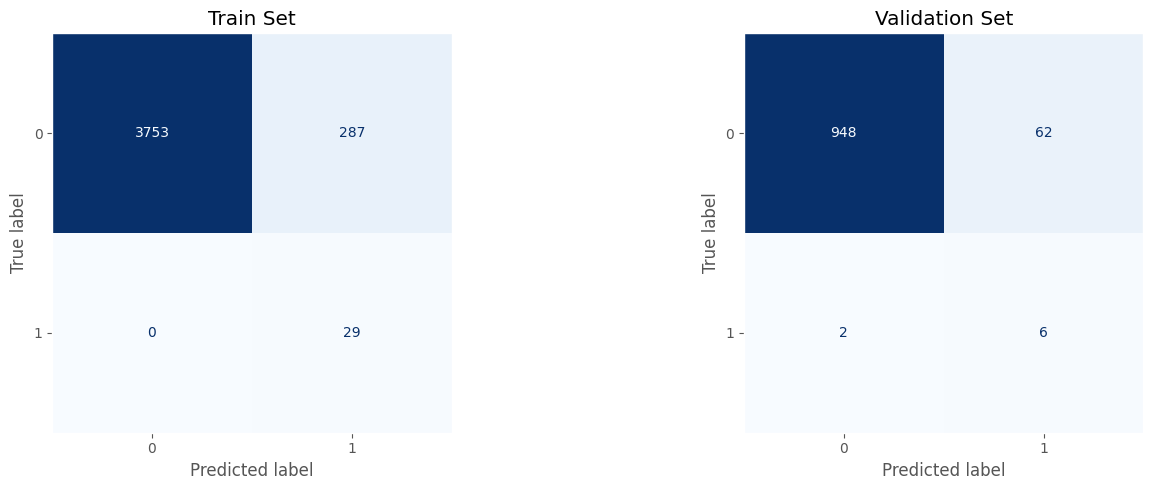

In [ ]:
y_val_pred = grid_search.predict(X_val_final)
y_train_pred = grid_search.predict(X_train_final)
compare_conf_matrices(y_train, y_train_pred, y_val, y_val_pred, "Train Set", "Validation Set")

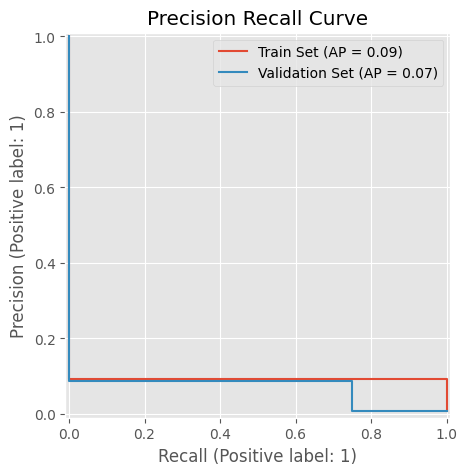

In [ ]:
compare_pr_curve(y_train, y_train_pred, y_val, y_val_pred, "Train Set", "Validation Set")

## **Final Performance on Test Dataset**

### **Preparing Test Dataset**

In [ ]:
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

y_test = y_test - 1 #Translating labels to 0 and 1

y_test.value_counts() # count exoplanets in test dataset

,count
LABEL,
0,565
1,5


In [ ]:
X_test_final = preprocess(X_test)

### **Making Predictions**

In [ ]:
y_test_pred = grid_search.predict(X_test_final)

### **Final Report**

================   Confusion Matrix and PR Curve ====================



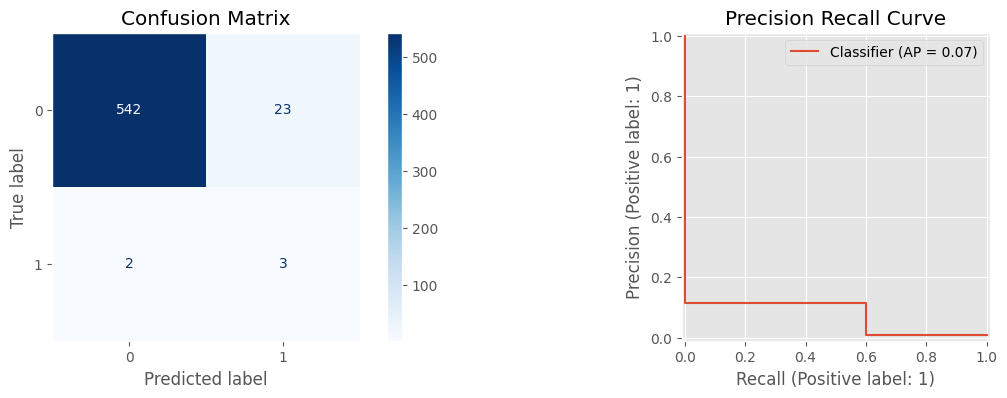



================ Classification Report =================

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       565
           1       0.12      0.60      0.19         5

    accuracy                           0.96       570
   macro avg       0.56      0.78      0.59       570
weighted avg       0.99      0.96      0.97       570



In [ ]:
show_performace_report(y_test, y_test_pred)

### **Summary of Results**

## **Future Improvements:**

### **Model Improvement:**
1.   **Dataset Enlargment:** Making the dataset larger by adding samples from other telescopes and missions.
2.   **Analyzing False +/-:** Individual Analysis of False Positives and Negatives to see where the model is failing.
3.   **Using CNN/RNN:** Using Neural Networks (It was mentioned somewhere that CNN and RNN are good at dealing with patterns in Time-Series Data)
4. **Bayes Theorem:** Using Bayes Theorem to combine the predictions of multiple models (Ensembling)

### **Code Improvement:**
1.   **Pipelining:** Using sklearn's `Pipeline` class to make preprocessing and prediction easier.

## **Resources:**

1. **Matplotlib:** https://matplotlib.org/stable/users/explain/quick_start.html
2. **Pandas:** https://pandas.pydata.org/docs/
3.  **Scikit-Learn:** https://scikit-learn.org/stable/
4.  **SMOTE:** https://en.wikipedia.org/wiki/Synthetic_minority_oversampling_technique
5. **Handling Imbalancing Datasets:** https://www.youtube.com/watch?v=flhjn6e6wnY
6. **Gaussian Smoothing:** https://medium.com/data-science/gaussian-smoothing-in-time-series-data-c6801f8a4dc3



---

